## Longitudinal MRI Data, Mental State Examination, and Education Attainment as Possible Diagnostic Factor for Alzheimer's Disease


### Introduction

Dementia, a chronic condition associated with aging and brain atrophy, involves widespread neuropsychological deficits that significantly hinder daily activities. Our project focuses on Alzheimer's disease, the most common form of dementia. Unfortunately, Alzheimer’s has neither definitive diagnosis nor cure. This exploratory analysis aims to identify predictors to help with the early detection and prevention of Alzheimer's disease.

Specifically, we want to see whether brain volume measures, mini-mental state examination score, and education attainment can predict an individual’s dementia state within a chosen dataset.

We use the longitudinal tabular dataset “Dementia Classification: Compare Classifiers” from Kaggle.com, with the pathway “oasis_longitudinal.csv”. This dataset has 15 variables and 373 rows, sampling from 150 participants aged 60-96. It examines the patterns in whether participants have dementia or not. This dataset includes the variables: 

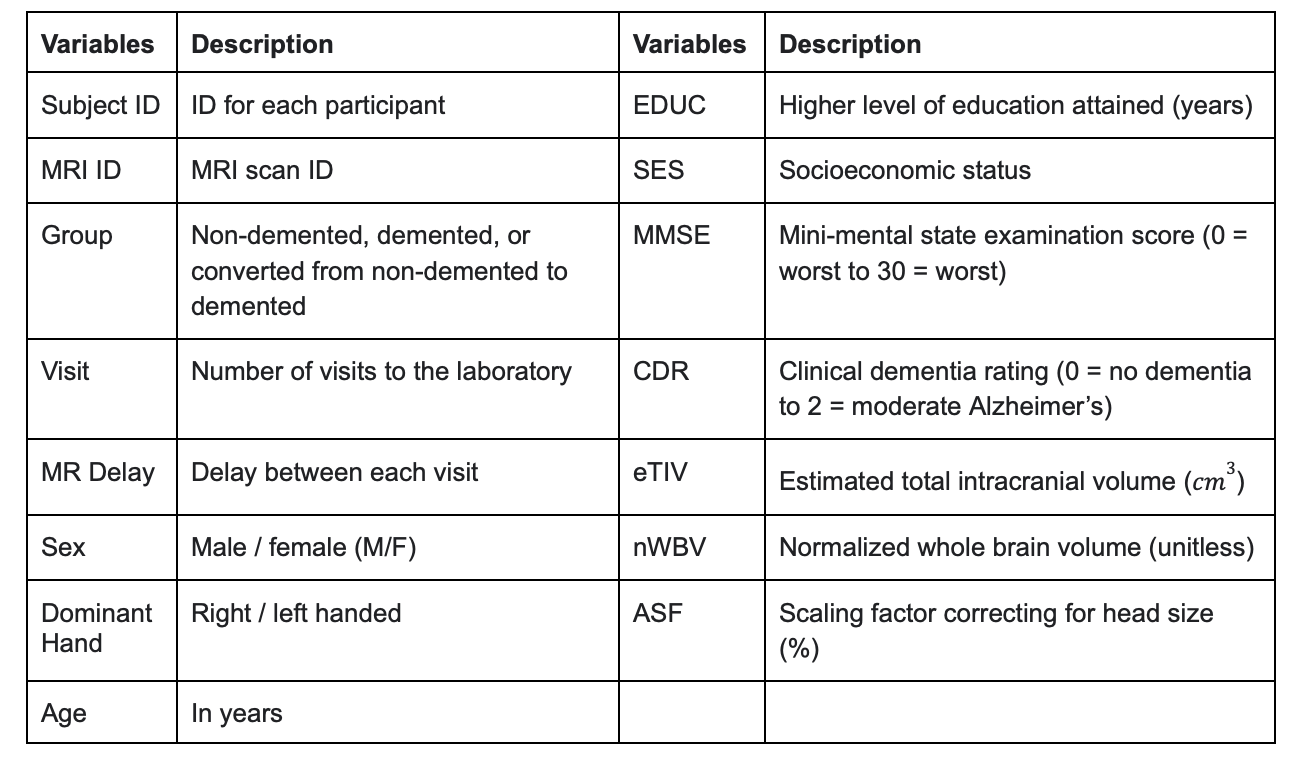

In [218]:
library("IRdisplay")
display_png(file = "Dataset column descriptors.png") 

### Preliminary exploratory data analysis

1. Demonstrate that the dataset can be read from the web into R 
2. Clean and wrangle your data into a tidy format

In [202]:
library(tidyverse)

In [215]:
url <- "https://raw.githubusercontent.com/churancc/Dementia_Project/main/oasis_longitudinal.csv"

dementia_df <- read_csv(url) |>
mutate(across(c("Group", "M/F", "Hand", "SES", "CDR"), as_factor)) |>
filter(Group %in% c("Nondemented", "Demented"))

unique_names <- make.names(names(dementia_df), unique=TRUE)
colnames(dementia_df) <- unique_names
colnames(dementia_df)[6] <- "Sex"

head(dementia_df) # Preview data set

Rows: 373 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Subject ID, MRI ID, Group, M/F, Hand
dbl (10): Visit, MR Delay, Age, EDUC, SES, MMSE, CDR, eTIV, nWBV, ASF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Subject.ID,MRI.ID,Group,Visit,MR.Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
<chr>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27,0,1987,0.696,0.883
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30,0,2004,0.681,0.876
OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NA,23,0.5,1678,0.736,1.046
OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NA,28,0.5,1738,0.713,1.010
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NA,22,0.5,1698,0.701,1.034
OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3,28,0,1215,0.710,1.444


3. Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

- **First table**: Throughout this longitudinal study (n = 150), each subject received a new brain MRI scan that determines their diagnostic label of dementia for every one to three visits.

  - The table below shows that throughout the entire study, 72 subjects remained non-demented since their fitst visit, 64 subjects were demented on their first visit maintained the same diagnosis for later scans. Meanwhile, 14 subjects who were not characterized by dementia later converted as demented at a subsequent visit.

In [204]:
class_table <- dementia_df |>
                    group_by(Subject.ID, Group) |>
                    summarize(Count = n()) |>

                    group_by(Group) |>
                    summarize(Count = n())

class_table

`summarise()` has grouped output by 'Subject.ID'. You can override using the
`.groups` argument.


Group,Count
<fct>,<int>
Nondemented,72
Demented,64


- Second table:  
  - Means of the predictor variables that may be used in the analysis.

4. Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

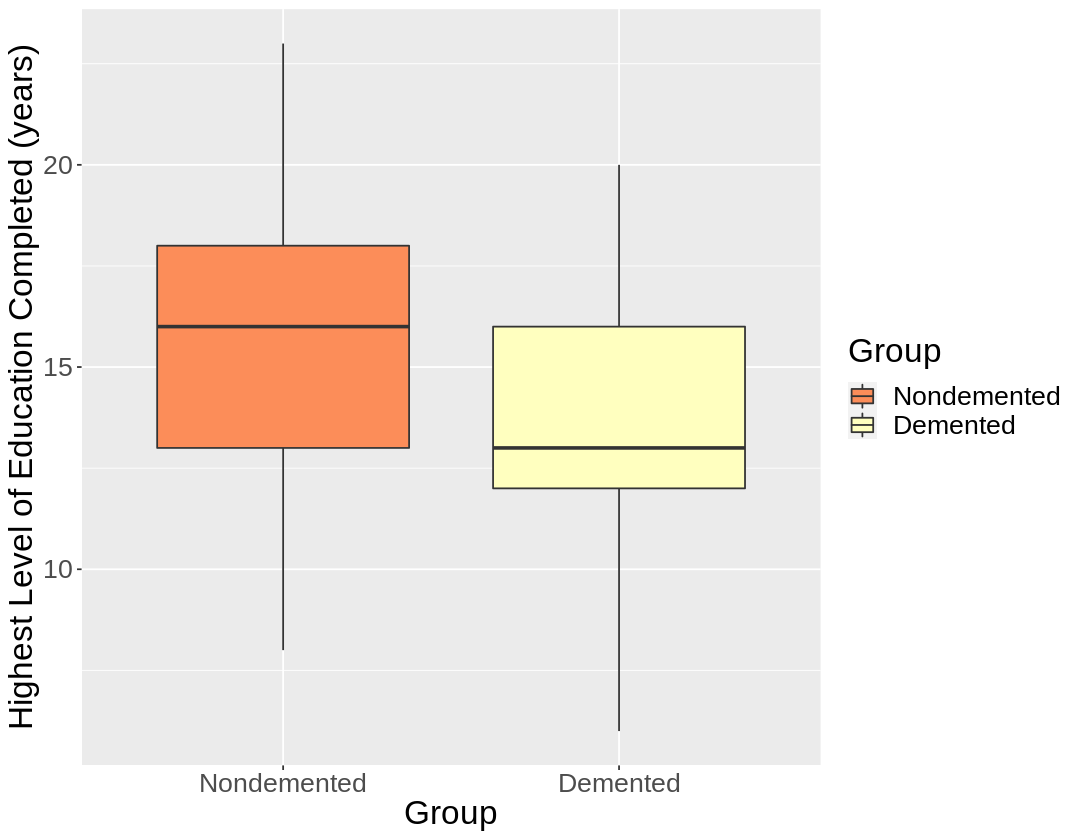

In [206]:
options(repr.plot.width = 9)

education_boxplot <- dementia_df |>
                     ggplot(aes(x = Group, y = EDUC, fill = Group)) + 
                     geom_boxplot(outlier.size = 2) +
                     theme(text = element_text(size = 20)) + 
                     labs(y = "Highest Level of Education Completed (years)") 

education_boxplot + scale_fill_brewer(palette = "RdYlBu")

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”


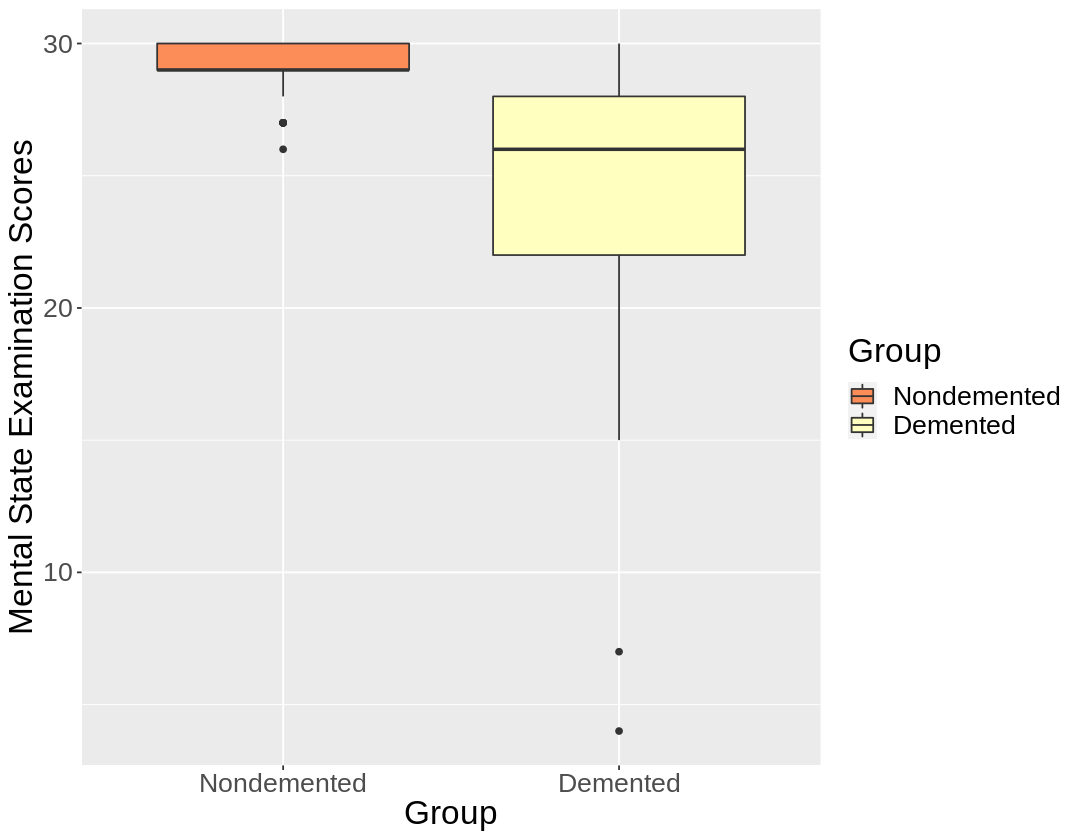

In [207]:
options(repr.plot.width = 9)

MMSE_boxplot <- dementia_df |>
                     ggplot(aes(x = Group, y = MMSE, fill = Group)) + 
                     geom_boxplot() +
                     theme(text = element_text(size = 20)) + 
                     labs(y = "Mental State Examination Scores") 

MMSE_boxplot + scale_fill_brewer(palette = "RdYlBu")

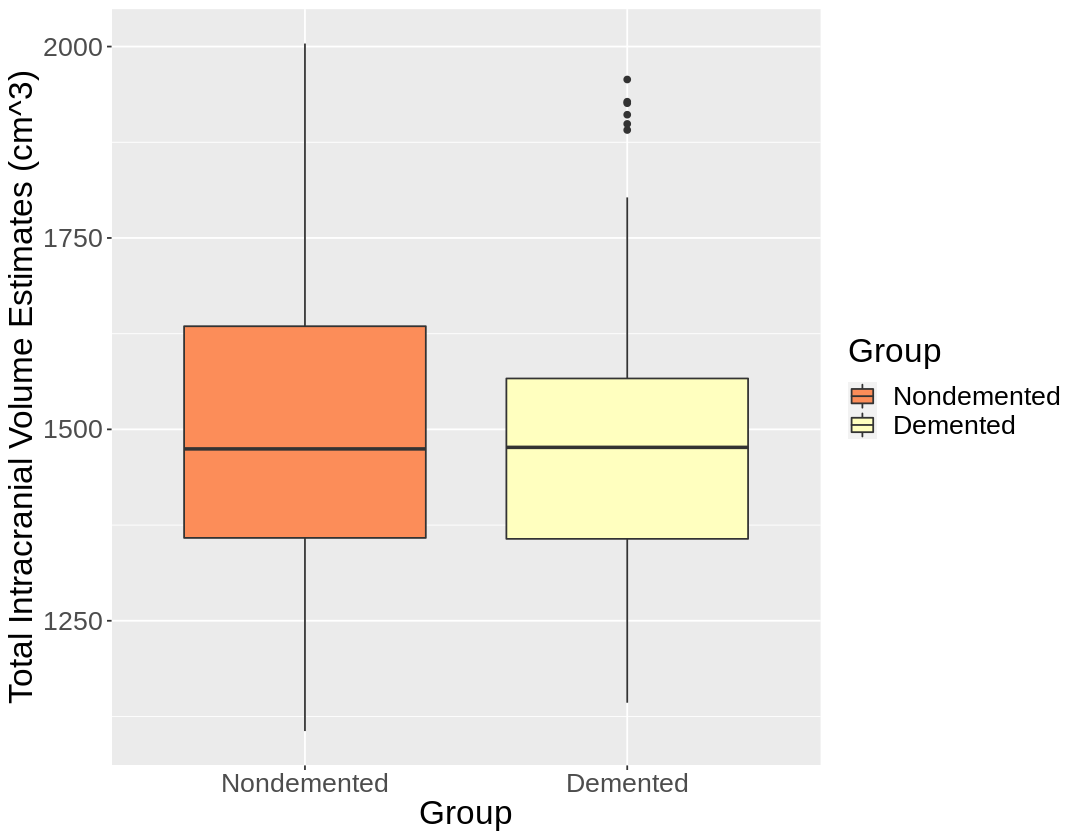

In [208]:
options(repr.plot.width = 9)

eTIV_boxplot <- dementia_df |>
                     ggplot(aes(x = Group, y = eTIV, fill = Group)) + 
                     geom_boxplot() +
                     theme(text = element_text(size = 20)) + 
                     labs(y = "Total Intracranial Volume Estimates (cm^3)") 

eTIV_boxplot + scale_fill_brewer(palette = "RdYlBu")

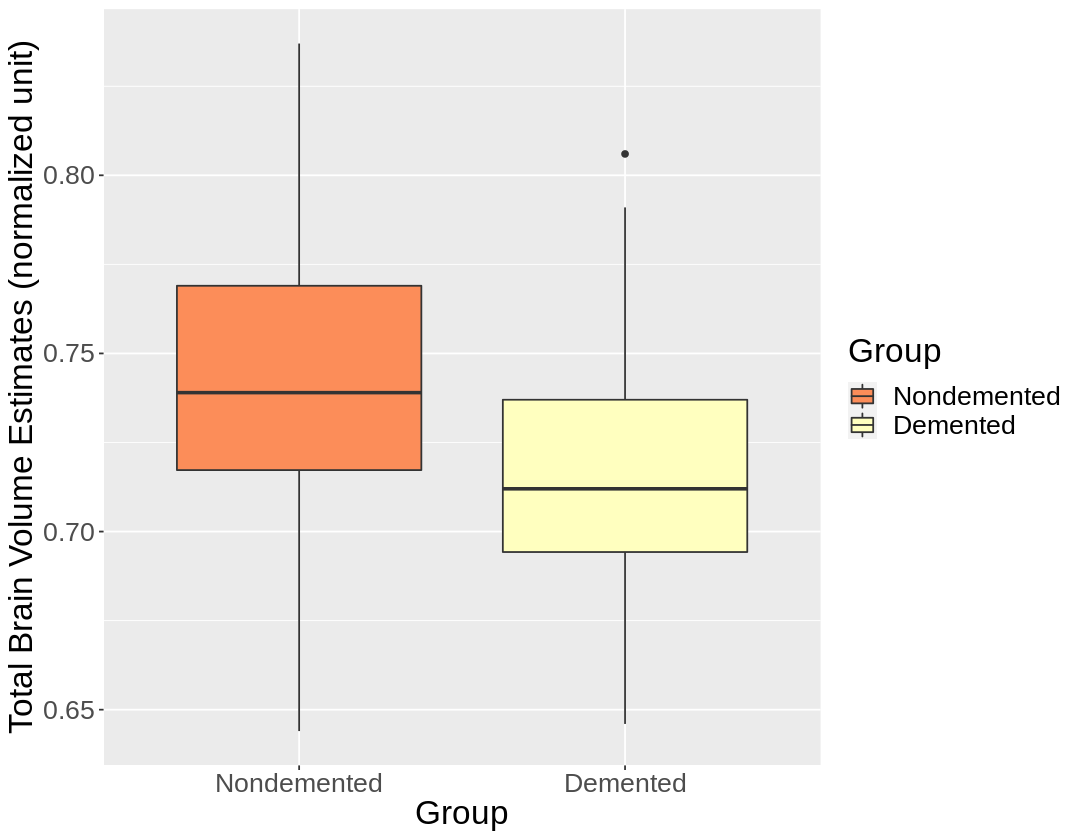

In [209]:
options(repr.plot.width = 9)

nWBV_boxplot <- dementia_df |>
                     ggplot(aes(x = Group, y = nWBV, fill = Group)) + 
                     geom_boxplot() +
                     theme(text = element_text(size = 20)) + 
                     labs(y = "Total Brain Volume Estimates (normalized unit)") 

nWBV_boxplot + scale_fill_brewer(palette = "RdYlBu")

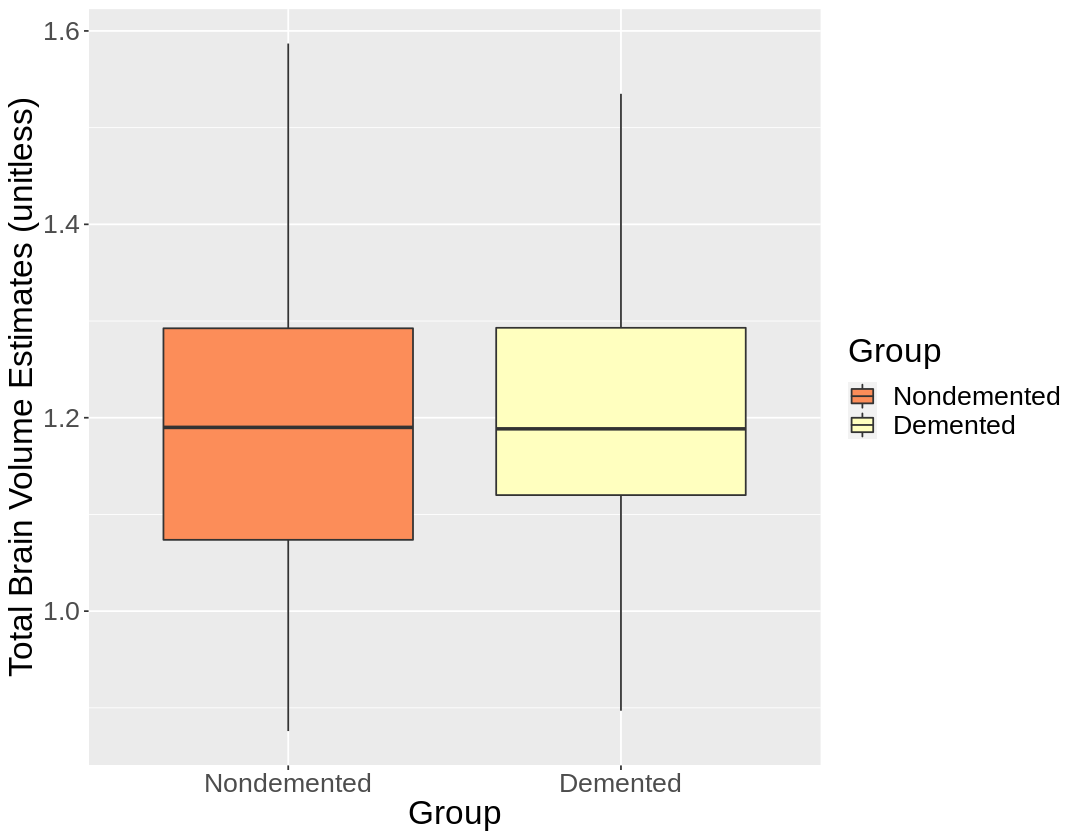

In [210]:
options(repr.plot.width = 9)

ASF_boxplot <- dementia_df |>
                     ggplot(aes(x = Group, y = ASF, fill = Group)) + 
                     geom_boxplot() +
                     theme(text = element_text(size = 20)) + 
                     labs(y = "Total Brain Volume Estimates (unitless)") 

ASF_boxplot + scale_fill_brewer(palette = "RdYlBu")

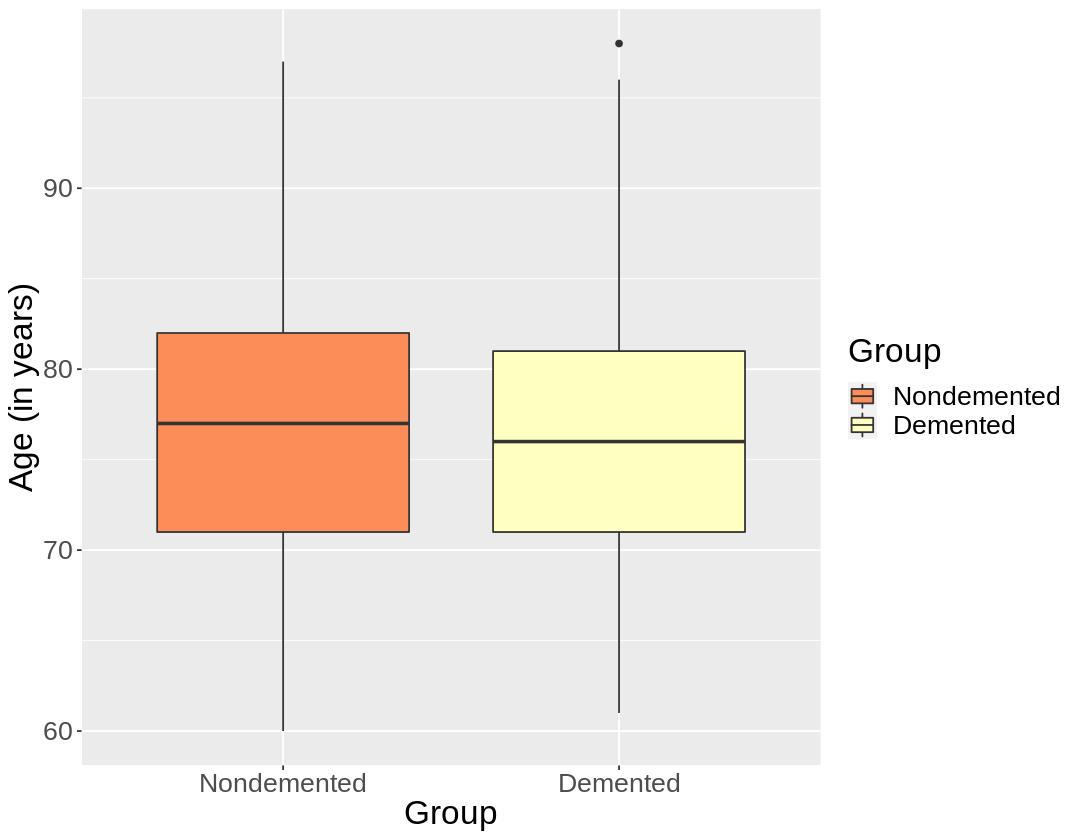

In [212]:
options(repr.plot.width = 9)

Age_boxplot <- dementia_df |>
                     ggplot(aes(x = Group, y = Age, fill = Group)) + 
                     geom_boxplot() +
                     theme(text = element_text(size = 20)) + 
                     labs(y = "Age (in years)") 

Age_boxplot + scale_fill_brewer(palette = "RdYlBu")